## test

In [3]:
import numpy as np
import scipy
from scipy.sparse import lil_matrix, diags, vstack
from scipy.sparse.linalg import lsqr, splu, spsolve
from scipy.spatial import cKDTree
from scipy.spatial.transform import Rotation as R

try:
    from matplotrender.src.matplotrender import *
except:
    #!pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

# import meshplot as mp

## simple test

In [263]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.spatial import cKDTree

from utils.laplacian import adjacency_matrix

def uniform_L(v, f):
    faces = f  # shape: (F, 3)
    v0, v1, v2 = faces[:, 0:1], faces[:, 1:2], faces[:, 2:3]  # shape: (F, 1)

    e01 = np.hstack([v0, v1])  # (F, 2)
    e12 = np.hstack([v1, v2])  # (F, 2)
    e20 = np.hstack([v2, v0])  # (F, 2)

    edges = np.vstack([e12, e20, e01])  # shape: (3F, 2)
    edges = np.sort(edges, axis=1)      # make edges in (min, max) form

    V = v.shape[0]
    edges_hash = V * edges[:, 0] + edges[:, 1]

    uqe, idx = np.unique(edges_hash, return_index=True)
    edges_unique = edges[idx]  # extract unique edges

    edges =  edges_unique.astype(int)  # store as integer array
    
    Adj = adjacency_matrix(V, edges, return_idx=False)

    degree = np.asarray(Adj.sum(axis=1)).squeeze()
    I_ = scipy.sparse.identity(V)
    D_ = scipy.sparse.diags(1/degree) @ Adj
    L = I_ - D_
    
    return L


def visualize_harmonic_cage_weights(pv, triangles, cage_idx_list, weights, ncols=6):
    n_cage = len(cage_idx_list)
    triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

    # subplot
    nrows = int(np.ceil(n_cage / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i in range(n_cage):
        ax = axs[i]
        w = weights[:, i]
        tpc = ax.tripcolor(triang, w, shading='gouraud', cmap='viridis')
        ax.plot(pv[:, 0], pv[:, 1], 'k.', markersize=2)
        # ax.plot(pv[cage_idx_list[i], 0], pv[cage_idx_list[i], 1], 'ro', markersize=6)
        # ax.set_title(f'Cage Vertex {cage_idx_list[i]}')
        ax.set_title(f'Cage Vertex {i}')
        ax.set_aspect('equal')
        fig.colorbar(tpc, ax=ax)

    # 나머지 subplot 비우기
    for j in range(n_cage, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.suptitle('Harmonic Weights for Each Cage Vertex', fontsize=16, y=1.02)
    plt.show()
    
def visualize_harmonic_weights(pv, triangles, cage_idx_list, weights,num=0):
    num_cages = len(pv)
    cols = int(np.ceil(np.sqrt(num_cages)))
    rows = int(np.ceil(num_cages / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

    weight_i = weights[:, num]
    # for i, cage_idx in enumerate(cage_idx_list):
    
    for i, cage_idx in enumerate(pv):
        ax = axes[i]

        tpc = ax.tripcolor(triang, weight_i, shading='gouraud', cmap='viridis')
        ax.plot(pv[:, 0], pv[:, 1], 'k.', markersize=1)
        ax.set_title(f" Vertex #{i}")
        ax.set_aspect('equal')
        fig.colorbar(tpc, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()
    

In [5]:
# # visualize_harmonic_weights(pv, triangles, cage_idx_list, solved_w,num=21)
# visualize_harmonic_cage_weights(pv, triangles, cage_idx_list, solved_w)
# visualize_harmonic_cage_weights(pv, triangles, cage_idx_list, solved_w3)

In [93]:
def make_triangle(pv):
    triangles = []
    index_map = {tuple(p): i for i, p in enumerate(pv)}

    for i, p in enumerate(pv):
        x, y = p
        right = (x + 0.5, y)
        up = (x, y + 0.5)
        diag = (x + 0.5, y + 0.5)
        
        if right in index_map and up in index_map and diag in index_map:
            a = i
            b = index_map[right]
            c = index_map[diag]
            d = index_map[up]
            
            triangles.append([a, b, c])
            triangles.append([a, c, d])

    triangles = np.array(triangles)
    return triangles

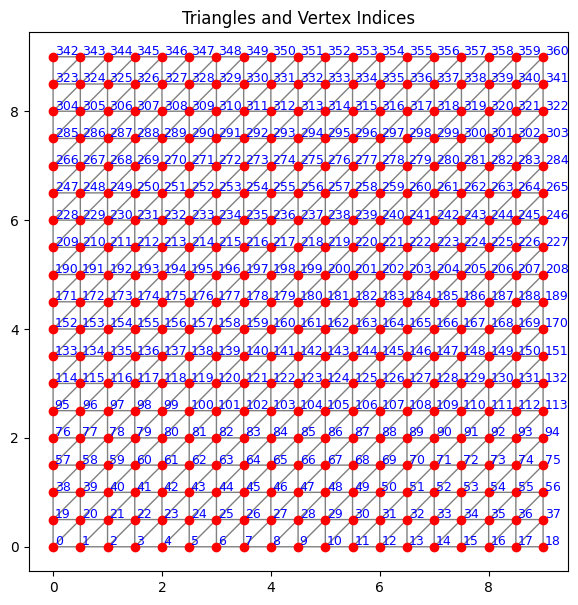

In [104]:
aa = np.tile(np.linspace(0,9,19), 19)
bb = np.linspace(0,9,19).repeat(19)
pv = np.c_[aa, bb]

tree = cKDTree(pv)
pairs = tree.query_pairs(r=0.51)

triangles = make_triangle(pv)

# 시각화
triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

plt.figure(figsize=(7,7))
plt.triplot(triang, color='gray', linewidth=1)
plt.plot(pv[:, 0], pv[:, 1], 'ro')

# 인덱스 라벨 추가
for i, (x, y) in enumerate(pv):
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Triangles and Vertex Indices")
plt.show()

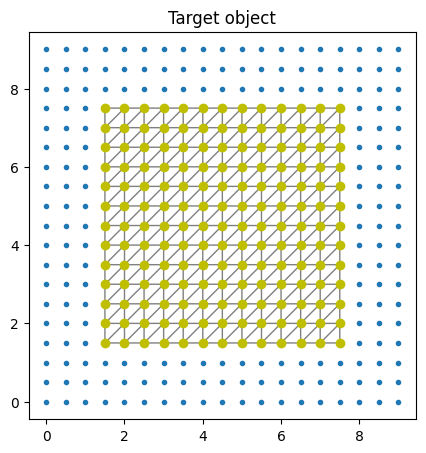

In [225]:
aa = np.tile(np.linspace(0,9,19), 19)
bb = np.linspace(0,9,19).repeat(19)
grid = np.c_[aa, bb]

obj_idx = np.array([np.arange(0,13) + 3*19+3 + 19*i for i in range(13)]).reshape(-1)
obj_pv=grid[obj_idx]

# tree = cKDTree(pv)
# pairs = tree.query_pairs(r=0.51)

obj_triangles = make_triangle(obj_pv)

# Visualize
obj_tri = tri.Triangulation(obj_pv[:, 0], obj_pv[:, 1], obj_triangles)

plt.figure(figsize=(5,8))
plt.triplot(obj_tri, color='gray', linewidth=1)
plt.plot(grid[:, 0], grid[:, 1], '.')
plt.plot(obj_pv[:, 0], obj_pv[:, 1], 'yo')

# for i, (x, y) in enumerate(grid):
#     plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Target object")
# plt.xticks([])
# plt.yticks([])
plt.show()

12 84


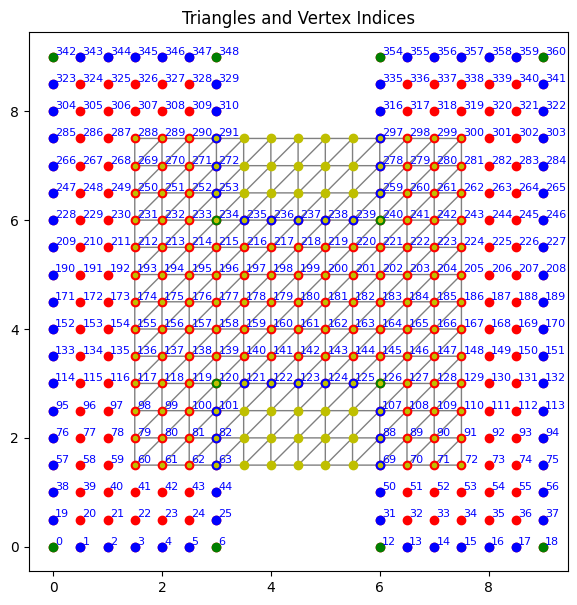

In [226]:
# aa = np.tile(np.linspace(0,9,19), 19)
# bb = np.linspace(0,9,19).repeat(19)
# pv = np.c_[aa, bb]


# aa = np.tile(np.linspace(2,7,15), 15)
# bb = np.linspace(2,7,15).repeat(15)
# obj_pv = np.c_[aa, bb]
# obj_pv = pv[30:]

asd = np.hstack(
    [np.arange(349-19*i, 354-19*i) for i in range(6)]
    +[np.arange(7+19*i, 12+19*i) for i in range(6)]
)
obj_idx_interior = np.setdiff1d(obj_idx, asd)
obj_idx_exterior = np.setdiff1d(obj_idx, obj_idx_interior)

grid_idx = np.arange(grid.shape[0])
pv_idx = np.setdiff1d(grid_idx, asd)
# pv = np.delete(grid, asd, axis=0)

pv = grid[pv_idx]

triangles = make_triangle(pv)

# Visualize
plt.figure(figsize=(7,7))

# triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)
# plt.triplot(triang, color='gray', linewidth=1)
plt.plot(pv[:, 0], pv[:, 1], 'ro')

obj_tri = tri.Triangulation(obj_pv[:, 0], obj_pv[:, 1], obj_triangles)
plt.triplot(obj_tri, color='gray', linewidth=1)

bd_idx_list = np.hstack(
    [np.arange(0, 14)]+[np.arange(287,300)]+[np.arange(90,97)]+[np.arange(204,211)]
    +[np.arange(223,293,14)]+[np.arange(224,294,14)]
    +[np.arange(14,85,14)]+[np.arange(103,199,19)]+[np.arange(217,287,14)]
    +[np.arange(20,91,14)]+[np.arange(21,96,14)]
    +[np.arange(27,84,14)]+[np.arange(102,216,19)]+[np.arange(216,301,14)]
    )
cage_idx_list = np.array([0,6,7,13,90,96,204,210,287,293,294,300])
bd_idx_list = np.setdiff1d(bd_idx_list, cage_idx_list)
print(len(cage_idx_list), len(bd_idx_list))

plt.plot(pv[bd_idx_list][:, 0], pv[bd_idx_list][:, 1], 'bo')
plt.plot(pv[cage_idx_list][:, 0], pv[cage_idx_list][:, 1], 'go')

plt.plot(grid[obj_idx_interior, 0], grid[obj_idx_interior, 1], 'y.')
plt.plot(grid[obj_idx_exterior, 0], grid[obj_idx_exterior, 1], 'yo')

## index
# for i, (x, y) in enumerate(pv):
#     plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')
    
for i in pv_idx:
    x, y = grid[i,0], grid[i,1]
    plt.text(x + 0.04, y + 0.04, str(i), fontsize=8, color='blue')

plt.gca().set_aspect('equal')
plt.title("Triangles and Vertex Indices")
plt.show()

(96, 2)
[ 0  1  2  3  4  5  6  7  8  9 10 11] [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95]
12 84


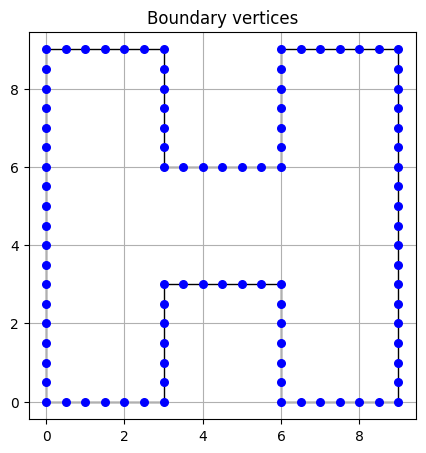

In [137]:
def find_knn_edges(V, k=4):
    """
    V: (n, 2) array of 2D points
    k: number of neighbors (excluding self)

    returns:
        E: (m, 2) array of undirected edge indices
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(V)
    d, indices = nbrs.kneighbors(V)

    # exclude self (index 0), and build undirected edge set
    E = set()
    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:
            edge = tuple(sorted((i, j)))
            E.add(edge)

    return np.array(list(E))

def plot_2d_points_and_edges(V, E, point_color='blue', edge_color='black', point_size=30, linewidth=1):
    """
    V : (n, 2) numpy array of 2D points
    E : (m, 2) numpy array of edge indices (each row is [i, j])
    """
    fig, ax = plt.subplots(figsize=(5,8))
    ax.scatter(V[:, 0], V[:, 1], c=point_color, s=point_size, zorder=2)

    for i, j in E:
        x = [V[i, 0], V[j, 0]]
        y = [V[i, 1], V[j, 1]]
        ax.plot(x, y, color=edge_color, linewidth=linewidth, zorder=1)

    ax.set_aspect('equal')
    ax.set_title('Boundary vertices')
    plt.grid(True)
    plt.show()

pv_init = pv[np.hstack((cage_idx_list, bd_idx_list))]
pv_init_cage_idx_list = np.arange(pv_init.shape[0])[:cage_idx_list.shape[0]]
pv_init_bd_idx_list = np.arange(pv_init.shape[0])[cage_idx_list.shape[0]:]
print(pv_init.shape)
print(pv_init_cage_idx_list, pv_init_bd_idx_list)
print(len(pv_init_cage_idx_list), len(pv_init_bd_idx_list))

# pv_bd_edge = find_knn_edges(pv[bd_idx_list], k=2)
# plot_2d_points_and_edges(pv[bd_idx_list], pv_bd_edge)

pv_edge = find_knn_edges(pv_init, k=2)
plot_2d_points_and_edges(pv_init, pv_edge)

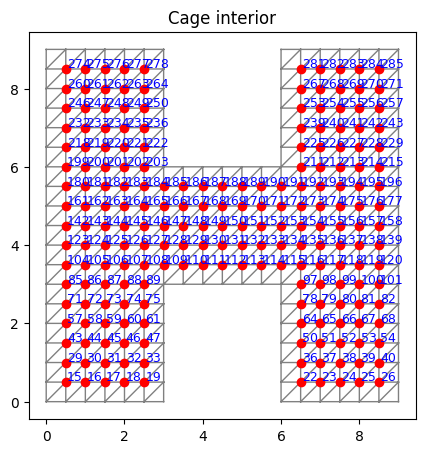

In [143]:
all_idx = np.arange(len(pv))
all_boundary_idx = np.hstack((cage_idx_list, bd_idx_list))
all_interior_idx = np.setdiff1d(all_idx, all_boundary_idx)


plt.figure(figsize=(5,8))
plt.triplot(triang, color='gray', linewidth=1)
plt.plot(pv[all_interior_idx, 0], pv[all_interior_idx, 1], 'ro')

for i in all_interior_idx:
    x, y = pv[i][0], pv[i][1]
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Cage interior")
plt.show()

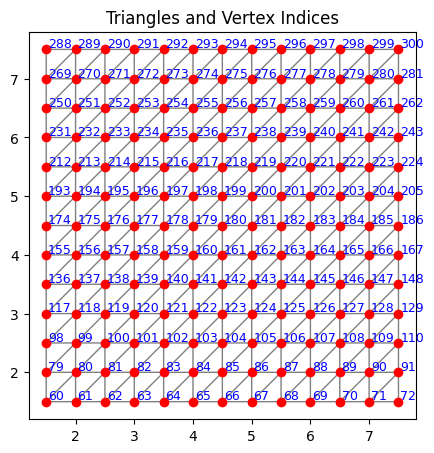

In [152]:
obj_pv = grid[obj_idx]

plt.figure(figsize=(5,8))
plt.triplot(obj_tri, color='gray', linewidth=1)
plt.plot(obj_pv[:,0], obj_pv[:,1], 'ro')

for i in grid_idx[obj_idx]:
    x, y = grid[i][0], grid[i][1]
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Triangles and Vertex Indices")
plt.show()

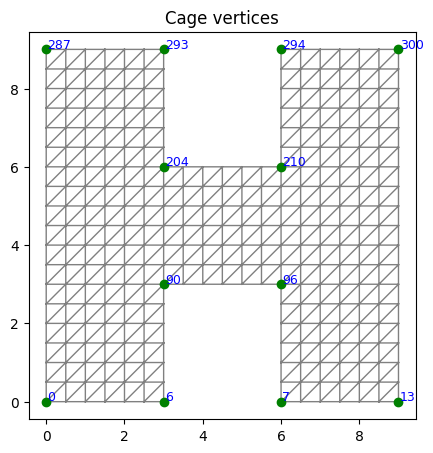

In [79]:
triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

plt.figure(figsize=(5,8))
plt.triplot(triang, color='gray', linewidth=1)
plt.plot(pv[cage_idx_list][:, 0], pv[cage_idx_list][:, 1], 'go')

for i, cdx in enumerate(cage_idx_list):
    xy = pv[cage_idx_list][i]
    plt.text(xy[0] + 0.03, xy[1] + 0.03, str(cdx), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Cage vertices")
plt.show()

In [10]:
# cage_v = pv[cage_idx_list]
# bd_v = pv[bd_idx_list]

# ## number to index mapping
# cage_dict={}
# for idx, cdx in enumerate(cage_idx_list):
#     cage_dict[cdx]=idx
    
# print(cage_idx_list)
# print(cage_v.shape)

pv_init_cage_v = pv_init[pv_init_cage_idx_list]
pv_init_bd_v = pv_init[pv_init_bd_idx_list]

## number to index mapping
pv_init_cage_dict={}
for idx, cdx in enumerate(pv_init_cage_idx_list):
    pv_init_cage_dict[cdx]=idx

In [11]:
print(len(pv_init_cage_idx_list))
print(len(pv_init_bd_idx_list))
print(pv_init_cage_v.shape)

12
84
(12, 2)


In [12]:
print(bd_idx_list.shape)
print(cage_idx_list.shape)

(84,)
(12,)


In [13]:
import numpy as np
from scipy.optimize import lsq_linear

def solve_affine_weights(v0, V):
    """
    v0: (d,) target point
    V: (n, d) matrix of basis points (each row is v_i)
    """
    n, d = V.shape

    # V.T @ w = v0  => (d x n) @ (n,) = (d,)
    A = V.T  # (d x n)
    b = v0   # (d,)

    # sum(w) = 1
    # minimize ||A w - b||^2 s.t. 1w = 1
    C = np.ones((1, n))
    d_ = np.array([1.0])

    lhs = np.vstack([A, C])         # (d+1) x n
    rhs = np.concatenate([b, d_])   # (d+1,)

    w, *_ = np.linalg.lstsq(lhs, rhs, rcond=None)
    return w

# bd_w_list = []
# for bdv in bd_v:
#     asdasd = solve_affine_weights(bdv, cage_v)
#     bd_w_list.append(asdasd)
# bd_w_list = np.array(bd_w_list)
# print(bd_w_list.shape)

pv_init_bd_w_list = []
for bdv in pv_init_bd_v:
    asdasd = solve_affine_weights(bdv, pv_init_cage_v)
    pv_init_bd_w_list.append(asdasd)
pv_init_bd_w_list = np.array(pv_init_bd_w_list)
print(pv_init_bd_w_list.shape)

(84, 12)


In [14]:
import numpy as np
from scipy.sparse import coo_matrix

def compute_graph_laplacian(n_vertices, edges):
    """
    Args:
        n_vertices: number of vertices
        edges: (m, 2) integer array

    Returns:
        L: (n, n) scipy sparse matrix
    """
    rows = []
    cols = []
    data = []

    deg = np.zeros(n_vertices)

    for i, j in edges:
        # off-diagonal
        rows += [i, j]
        cols += [j, i]
        data += [-1, -1]
        # degree count
        deg[i] += 1
        deg[j] += 1

    rows += list(range(n_vertices))
    cols += list(range(n_vertices))
    data += list(deg)

    L = coo_matrix((data, (rows, cols)), shape=(n_vertices, n_vertices))
    return L


L_init = compute_graph_laplacian(pv_init.shape[0], pv_edge)
L_init.shape

L_init = L_init.tolil()

L_init[pv_init_cage_idx_list]=0
L_init[pv_init_cage_idx_list, pv_init_cage_idx_list]=1

L_init[pv_init_bd_idx_list]=0
L_init[pv_init_bd_idx_list][:, pv_init_cage_idx_list]=pv_init_bd_w_list
print(L_init[pv_init_bd_idx_list][:, pv_init_cage_idx_list].shape)

L_init = L_init.tocsr()

(84, 12)


In [43]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

def compute_graph_laplacian(n_vertices, edges):
    """
    Graph Laplacian (uniform weights).
    """
    rows, cols, data = [], [], []
    deg = np.zeros(n_vertices)
    for i, j in edges:
        rows += [i, j]
        cols += [j, i]
        data += [-1, -1]
        deg[i] += 1
        deg[j] += 1
    rows += list(range(n_vertices))
    cols += list(range(n_vertices))
    data += list(deg)
    L = coo_matrix((data, (rows, cols)), shape=(n_vertices, n_vertices))
    return L.tocsr()

def solve_harmonic_coordinates(V, E, boundary_idx, boundary_values):
    """
    Harmonic coordinates solver for 2D graph.

    Parameters:
    -----------
    V : (n,2) array of vertices
    E : (m,2) array of edges
    boundary_idx : (k,) indices of boundary vertices
    boundary_values : (k,p) matrix of known boundary values
                      (each column = one coordinate function)

    Returns:
    --------
    H : (n,p) harmonic coordinates
    """
    n = len(V)
    L = compute_graph_laplacian(n, E)

    # Interior vertices (to solve for)
    all_idx = np.arange(n)
    interior_idx = np.setdiff1d(all_idx, boundary_idx)

    ## Build submatrices
    L_ii = L[interior_idx][:, interior_idx]
    L_ib = L[interior_idx][:, boundary_idx]

    ## Solve L_ii * x = - L_ib * boundary_values for each coordinate
    rhs = -L_ib @ boundary_values
    X = np.zeros((n, boundary_values.shape[1]))
    X[boundary_idx] = boundary_values
    X[interior_idx] = spsolve(L_ii, rhs)
    # X[interior_idx] = spsolve(L_ii, X[interior_idx])
        
    # L_ii = L
    # L_ib = L[:, boundary_idx]
    # rhs = -L_ib @ boundary_values
    # lu = lu_factor_ata(L_ii)
    # X = lu.solve(L_ii.T @ rhs )

    return X

In [44]:
# V = pv_init
# E = pv_edge
# n = len(V)
# L = compute_graph_laplacian(n, E)

# boundary_idx = pv_init_cage_idx_list
# boundary_values = np.eye(len(boundary_idx))

# all_idx = np.arange(n)
# interior_idx = np.setdiff1d(all_idx, boundary_idx)

# print(L.todense())
# print(boundary_idx)
# L_ib = L[interior_idx][:, boundary_idx]
# print(L_ib.todense())
# rhs = -L_ib @ boundary_values
# print(rhs)

(12, 12) (96, 2)
(96, 12)


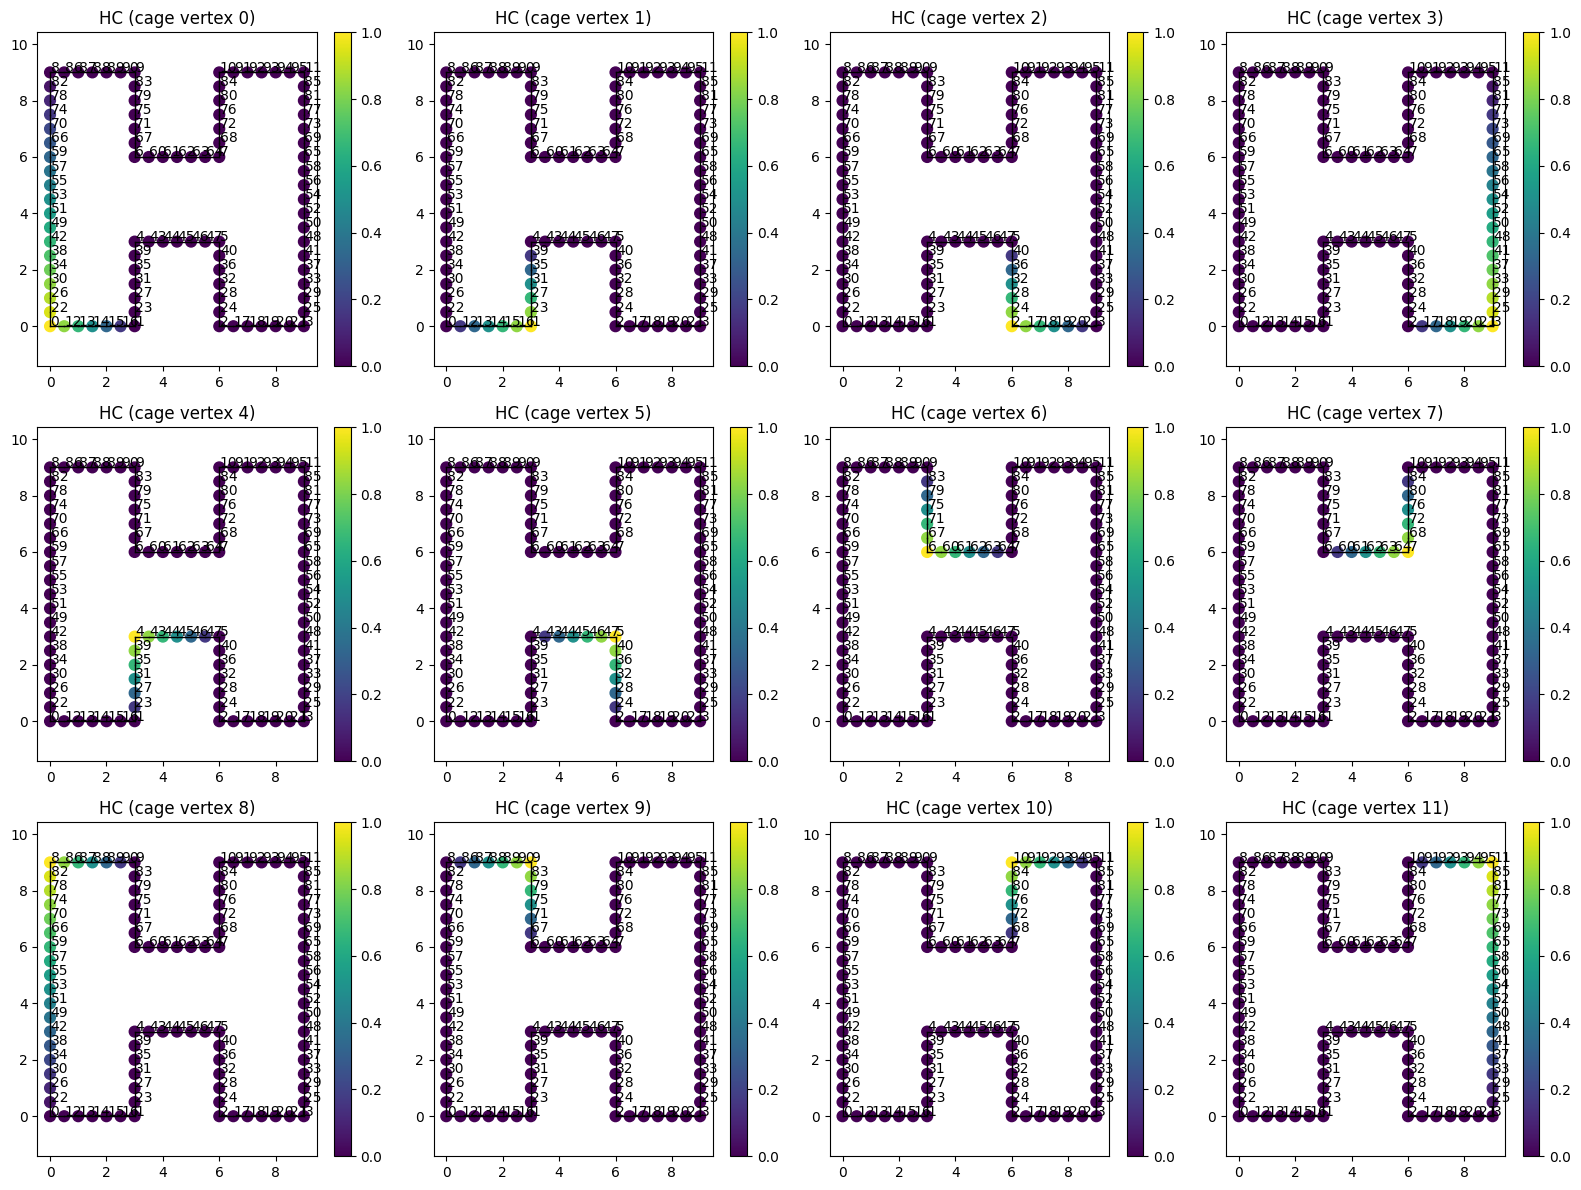

In [45]:
V = pv_init
E = pv_edge

boundary_idx = pv_init_cage_idx_list
boundary_values = np.eye(len(boundary_idx))

# boundary_idx = np.array([0,1])
# boundary_values = np.array([[1,0],[0,1]])  # 0->(1,0), 1->(0,1)
print(boundary_values.shape, V.shape)
H = solve_harmonic_coordinates(V, E, boundary_idx, boundary_values)
print(H.shape)

num_cages = len(boundary_idx)
cols = int(np.ceil(np.sqrt(num_cages)))
rows = int(np.ceil(num_cages / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()
for C_i in range(len(boundary_idx)):
    ax = axes[C_i]
    tpc = ax.scatter(V[:,0], V[:,1], c=H[:,C_i], cmap='viridis', s=60)
    for i,j in E:
        ax.plot([V[i,0], V[j,0]], [V[i,1], V[j,1]], 'k-', lw=1)
    for i,xy in enumerate(V):
        ax.text(xy[0]+0.02, xy[1]+0.02, str(i))
    ax.set_title(f'HC (cage vertex {C_i})')
    ax.axis('equal')
    fig.colorbar(tpc, ax=ax)
    # plt.colorbar(fig, ax=ax)
plt.tight_layout()
plt.show()

In [58]:
print(pv.shape, triangles.shape, H.shape,len(cage_idx_list))
L = igl.cotmatrix(pv, triangles)

(301, 2) (504, 3) (96, 12) 12


In [238]:
# Interior vertices (to solve for)
all_n = len(pv)
all_idx = np.arange(all_n)
all_boundary_idx = np.hstack((cage_idx_list, bd_idx_list))
all_interior_idx = np.setdiff1d(all_idx, all_boundary_idx)

## Build submatrices
L_ii = L[all_interior_idx][:, all_interior_idx]
L_ib = L[all_interior_idx][:, all_boundary_idx]

## Solve L_ii * x = - L_ib * boundary_values for each coordinate
rhs = -L_ib @ H
# rhs = -L_ib @ np.eye(len(cage_idx_list))
print(rhs.shape, H.shape)
X = np.zeros((all_n, H.shape[1]))
X[all_boundary_idx] = H
X[all_interior_idx] = spsolve(L_ii, rhs)
 
solved_w = X

(205, 12) (96, 12)


In [239]:
H.shape

(96, 12)

In [ ]:
b = np.zeros((pv.shape[0], cage_v.shape[0]))
b[cage_idx_list] = H[pv_init_cage_idx_list]#np.eye(cage_v.shape[0])
b[bd_idx_list] = H[pv_init_bd_idx_list]#np.eye(bd_v.shape[0])
# print(cage_idx_list)
# print(b)

In [632]:
Atb = A.T @ b
solved_w = lu_.solve(Atb)
# solved_w = solved_w / solved_w.sum(1)[:,None]

# solved_w = []
# for k in range(cage_v.shape[0]):
#     Atb = A.T @ b[:,k]
#     solved_w.append(lu_.solve(Atb))
# solved_w = np.array(solved_w).transpose(1,0)
print(solved_w.shape)

(301, 12)


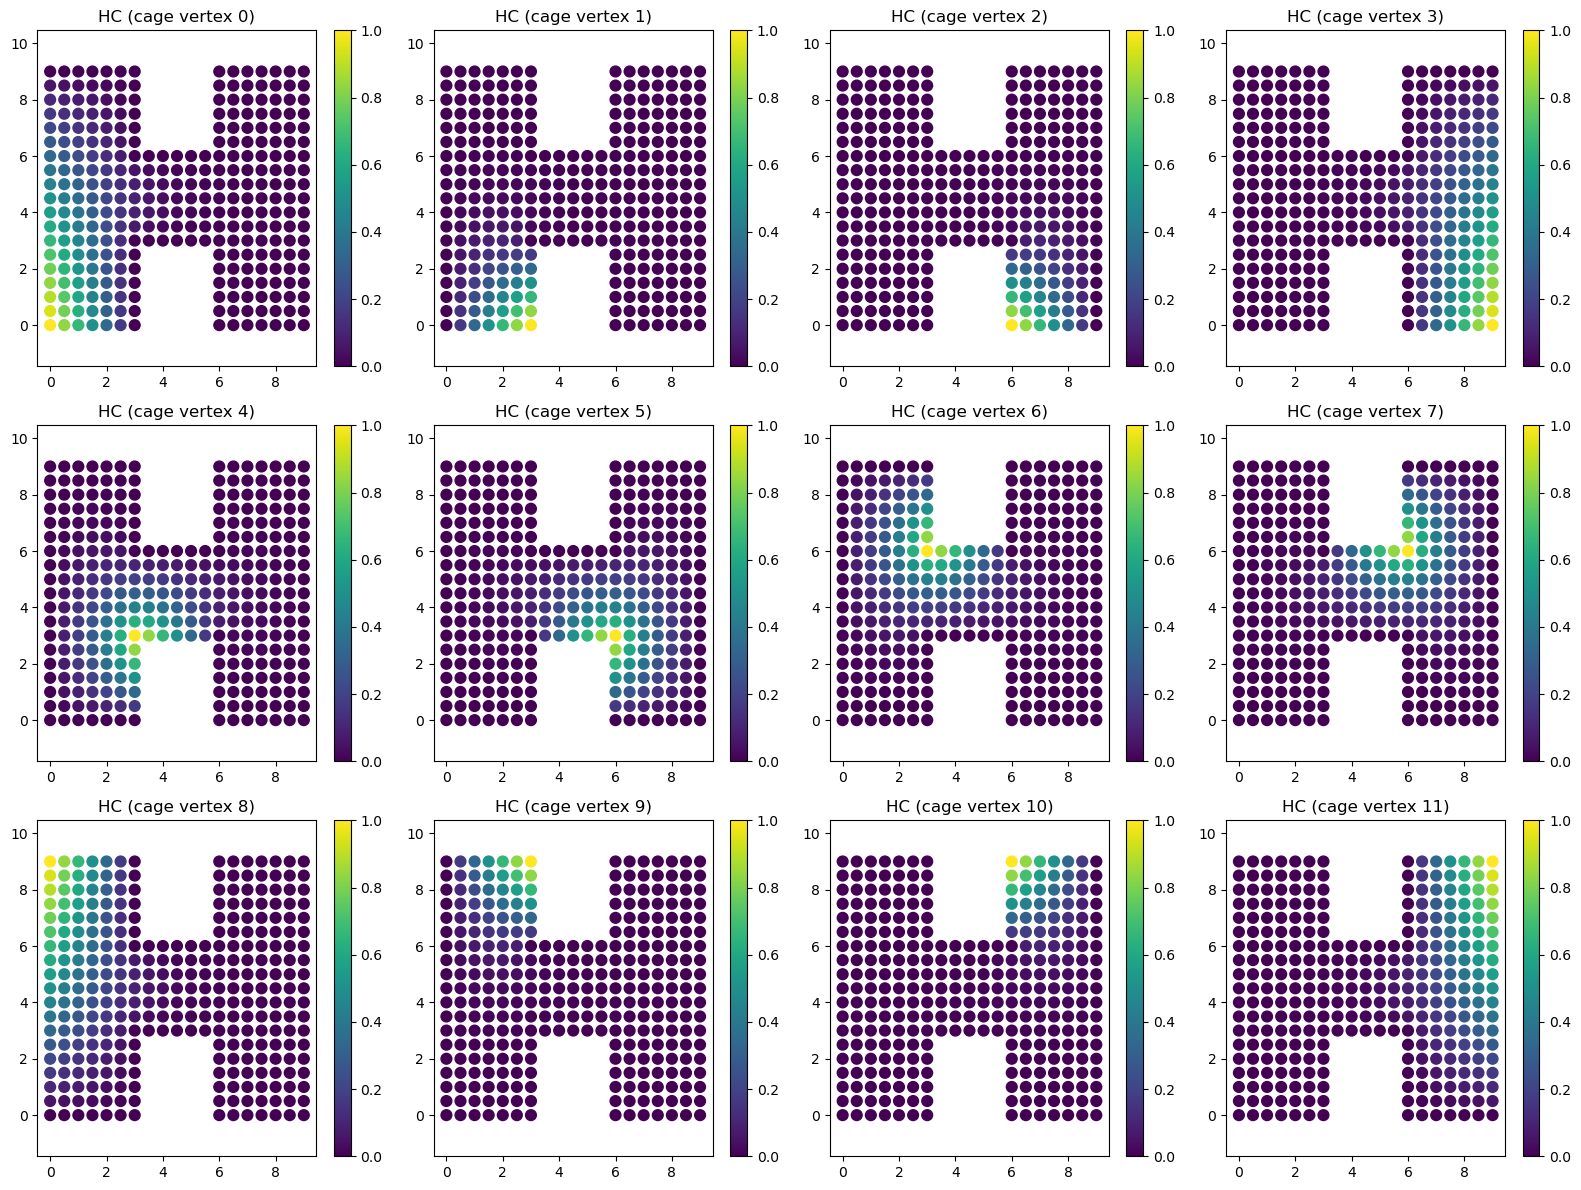

In [648]:
V = pv
I, J = triangles[:, [0,1,2]], triangles[:, [1,2,0]]
edges = np.concatenate([I.reshape(-1,1), J.reshape(-1,1)], axis=1)
E = np.unique(np.sort(edges, axis=1), axis=0)


num_cages = len(boundary_idx)
cols = int(np.ceil(np.sqrt(num_cages)))
rows = int(np.ceil(num_cages / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()
for C_i in range(len(boundary_idx)):
    ax = axes[C_i]
    # for i,j in E:
    #     ax.plot([V[i,0], V[j,0]], [V[i,1], V[j,1]], 'k-', lw=1)
    tpc = ax.scatter(V[:,0], V[:,1], c=solved_w[:,C_i], cmap='viridis', s=60)
    # for i,xy in enumerate(V):
    #     ax.text(xy[0]+0.02, xy[1]+0.02, str(i))
    ax.set_title(f'HC (cage vertex {C_i})')
    ax.axis('equal')
    fig.colorbar(tpc, ax=ax)
    # plt.colorbar(fig, ax=ax)
plt.tight_layout()
plt.show()

In [240]:
HC_grid = np.zeros((grid.shape[0], num_cages))
# solved_w = solved_w / solved_w.sum(0)
HC_grid[pv_idx] = solved_w


HC_obj = HC_grid[obj_idx]
# HC_obj[obj_idx_exterior] = 1
# plt.plot(grid[obj_idx_interior, 0], grid[obj_idx_interior, 1], 'y.')
# plt.plot(grid[obj_idx_exterior, 0], grid[obj_idx_exterior, 1], 'yo')
# print(HC_grid.shape,HC_obj.shape, solved_w.shape, grid[pv_idx].shape,pv[cage_idx_list].shape)

In [241]:
solved_w.sum(0)

array([35.20970674, 14.00420889, 14.00420889, 35.20970674, 26.03608437,
       26.03608437, 26.03608437, 26.03608437, 35.20970674, 14.00420889,
       14.00420889, 35.20970674])

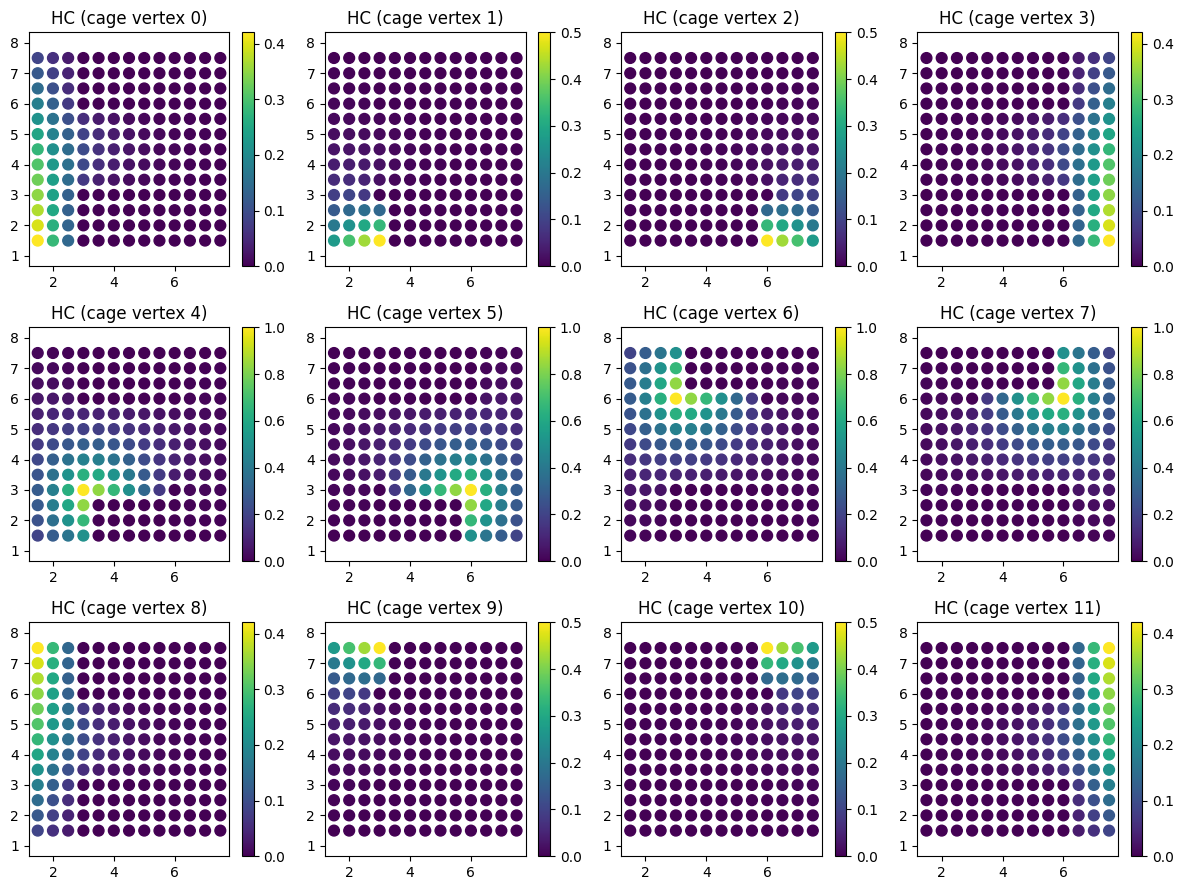

In [253]:
V = grid[obj_idx]

num_cages = len(boundary_idx)
cols = int(np.ceil(np.sqrt(num_cages)))
rows = int(np.ceil(num_cages / cols))

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axes = axes.flatten()
for C_i in range(len(boundary_idx)):
    ax = axes[C_i]
    # for i,j in E:
    #     ax.plot([V[i,0], V[j,0]], [V[i,1], V[j,1]], 'k-', lw=1)
    tpc = ax.scatter(V[:,0], V[:,1], c=HC_obj[:,C_i], cmap='viridis', s=60)
    # for i,xy in enumerate(V):
    #     ax.text(xy[0]+0.02, xy[1]+0.02, str(i))
    ax.set_title(f'HC (cage vertex {C_i})')
    ax.axis('equal')
    fig.colorbar(tpc, ax=ax)
    # plt.colorbar(fig, ax=ax)
plt.tight_layout()
plt.show()

In [252]:
HC_obj[10].sum()

np.float64(0.9999999999999999)

In [254]:
new_cage_v = pv[cage_idx_list].copy()
new_cage_v[2] = new_cage_v[2] + np.array([2,-1])
# new_cage_v[3] = new_cage_v[3] + np.array([2,0])
new_cage_v[3] = new_cage_v[3] + np.array([1,3])
# new_cage_v[5] = new_cage_v[5] + np.array([.5,0])


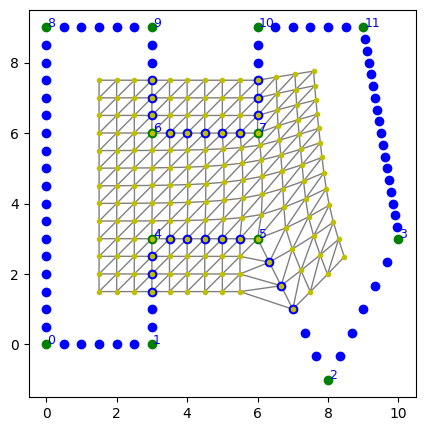

In [255]:
new_grid = HC_grid @ new_cage_v
new_grid[obj_idx_exterior] = grid[obj_idx_exterior]
new_pv = new_grid[obj_idx]
new_bd_v = new_grid[pv_idx][bd_idx_list]
# new_pv = solved_w @ cage_v
# new_pv = (solved_w @ cage_v) / solved_w.sum(1)[:,None]

obj_tri = tri.Triangulation(new_pv[:, 0], new_pv[:, 1], obj_triangles)

plt.figure(figsize=(5,8))
# plt.figure(figsize=(8, 8))
plt.triplot(obj_tri, color='gray', linewidth=1)
# plt.plot(grid[:, 0], grid[:, 1], '.')
plt.plot(new_bd_v[:, 0], new_bd_v[:, 1], 'bo')
plt.plot(new_cage_v[:, 0], new_cage_v[:, 1], 'go')

plt.plot(new_pv[:, 0], new_pv[:, 1], 'y.')

# for i in grid_idx[pv_idx][cage_idx_list]:
#     x,y = grid[i][0], grid[i][1]
#     plt.text(x + 0.03, y + 0.03, str(i), fontsize=8, color='black')

for i, (x, y) in enumerate(new_cage_v):
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')
# for i, (x, y) in enumerate(new_bd_v):
#     plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
# plt.title("Triangles and Vertex Indices")
plt.show()

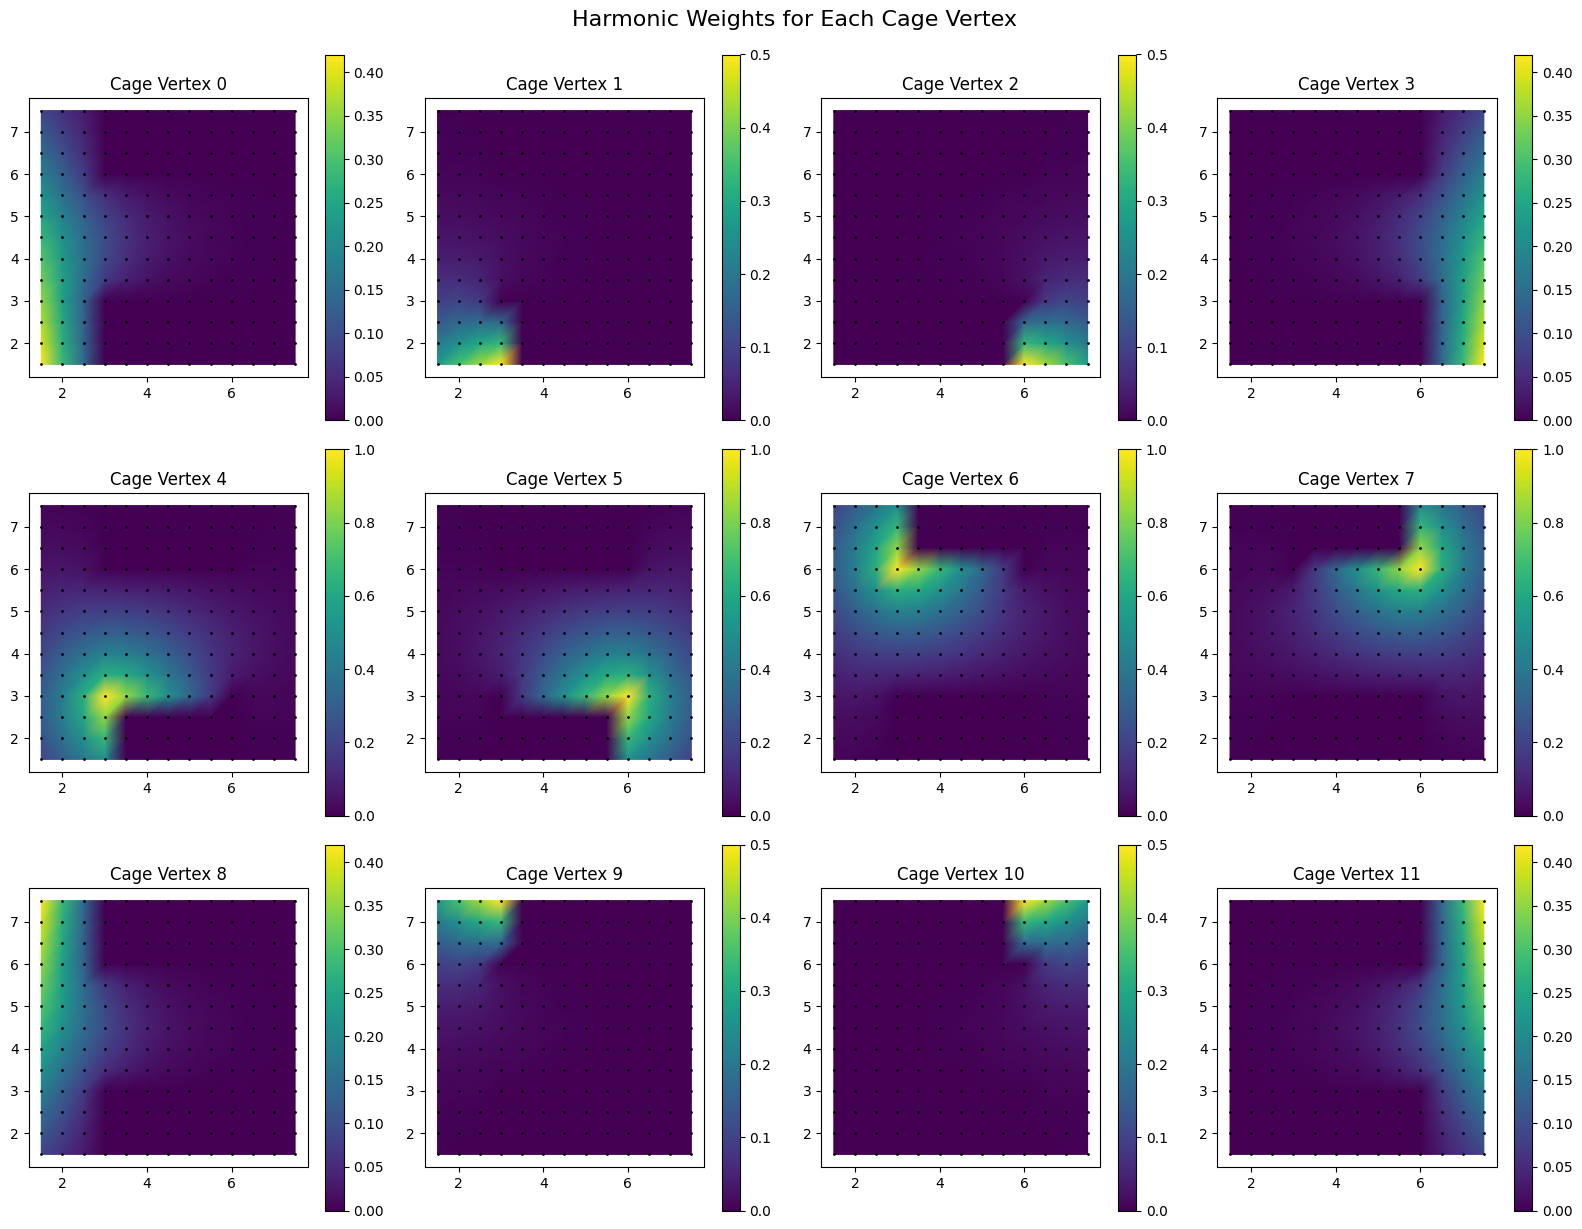

In [265]:
obj_pv = grid[obj_idx]
obj_triangles = make_triangle(obj_pv)

visualize_harmonic_cage_weights(obj_pv, obj_triangles, cage_idx_list, HC_obj, ncols=4)

In [345]:
tau = .5
m = igl.massmatrix(pv, triangles, igl.MASSMATRIX_TYPE_BARYCENTRIC) # mass matrix in libigl
s = m - tau * L
solved_w3 = spsolve(s, m @ solved_w)
solved_w3 = solved_w3 / solved_w3.sum(1)[:,None]
# solved_w3[cage_idx_list] = np.eye(cage_v.shape[0])
# print(solved_w.shape, solved_w3.shape)

In [313]:
# visualize_harmonic_weights(pv, triangles, cage_idx_list, solved_w)

In [193]:
solved_w[cage_idx_list] = np.eye(cage_v.shape[0])
Atb = A.T @ solved_w
solved_w2 = lu_.solve(Atb)

In [ ]:
new_cage_v = cage_v.copy()
new_cage_v[cage_dict[0]] = new_cage_v[cage_dict[0]] - np.array([0.25, -0.25])
new_cage_v[cage_dict[5]] = new_cage_v[cage_dict[5]] - np.array([0.25, -0.])
new_cage_v[cage_dict[10]] = new_cage_v[cage_dict[10]] - np.array([0.25, .25])

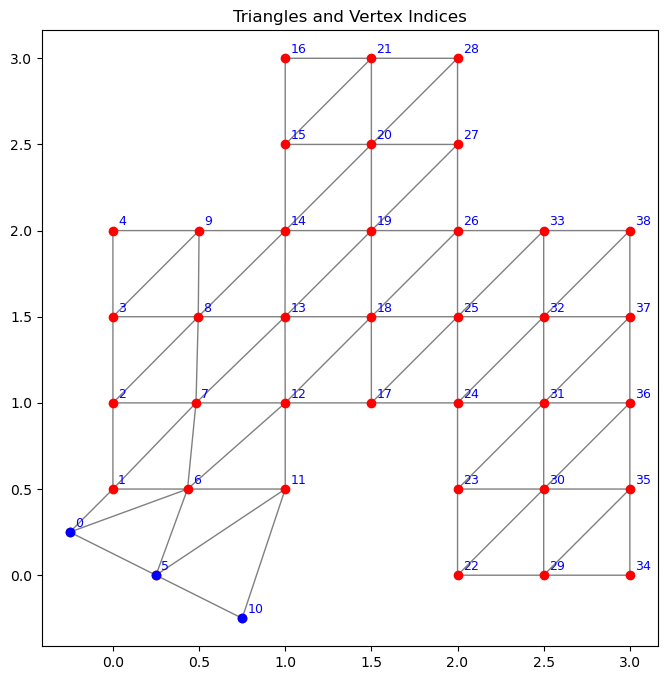

In [387]:
new_pv = solved_w @ new_cage_v
# new_pv = solved_w @ cage_v
# new_pv = (solved_w @ cage_v) / solved_w.sum(1)[:,None]

triang = tri.Triangulation(new_pv[:, 0], new_pv[:, 1], triangles)

# plt.figure(figsize=(4, 6))
plt.figure(figsize=(8, 8))
plt.triplot(triang, color='gray', linewidth=1)
plt.plot(new_pv[:, 0], new_pv[:, 1], 'ro')

for i in [0, 5 , 10]:
    plt.plot(new_pv[i, 0], new_pv[i, 1], 'bo')

for i, (x, y) in enumerate(new_pv):        
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Triangles and Vertex Indices")
plt.show()

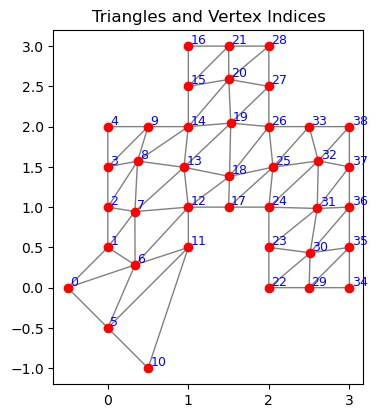

In [340]:
new_pv = solved_w3 @ new_cage_v
# new_pv = solved_w @ cage_v
# new_pv = (solved_w @ cage_v) / solved_w.sum(1)[:,None]

triang = tri.Triangulation(new_pv[:, 0], new_pv[:, 1], triangles)

plt.figure(figsize=(4, 6))
plt.triplot(triang, color='gray', linewidth=1)
plt.plot(new_pv[:, 0], new_pv[:, 1], 'ro')

for i, (x, y) in enumerate(new_pv):
    plt.text(x + 0.03, y + 0.03, str(i), fontsize=9, color='blue')

plt.gca().set_aspect('equal')
plt.title("Triangles and Vertex Indices")
plt.show()

In [75]:
print(solved_v[0])
print(solved_v[7])

[-0.7871996   0.35252523  0.54597791  0.22832345  0.14356004 -0.66953567
 -0.58654541  0.88038186  0.11076116 -0.81844131 -0.16169101]
[ 0.83199938  0.23302157  1.00911131  0.13354205  0.02364438 -0.78503996
 -0.70163584  0.76258972 -0.00850822 -0.93404641 -0.27812317]


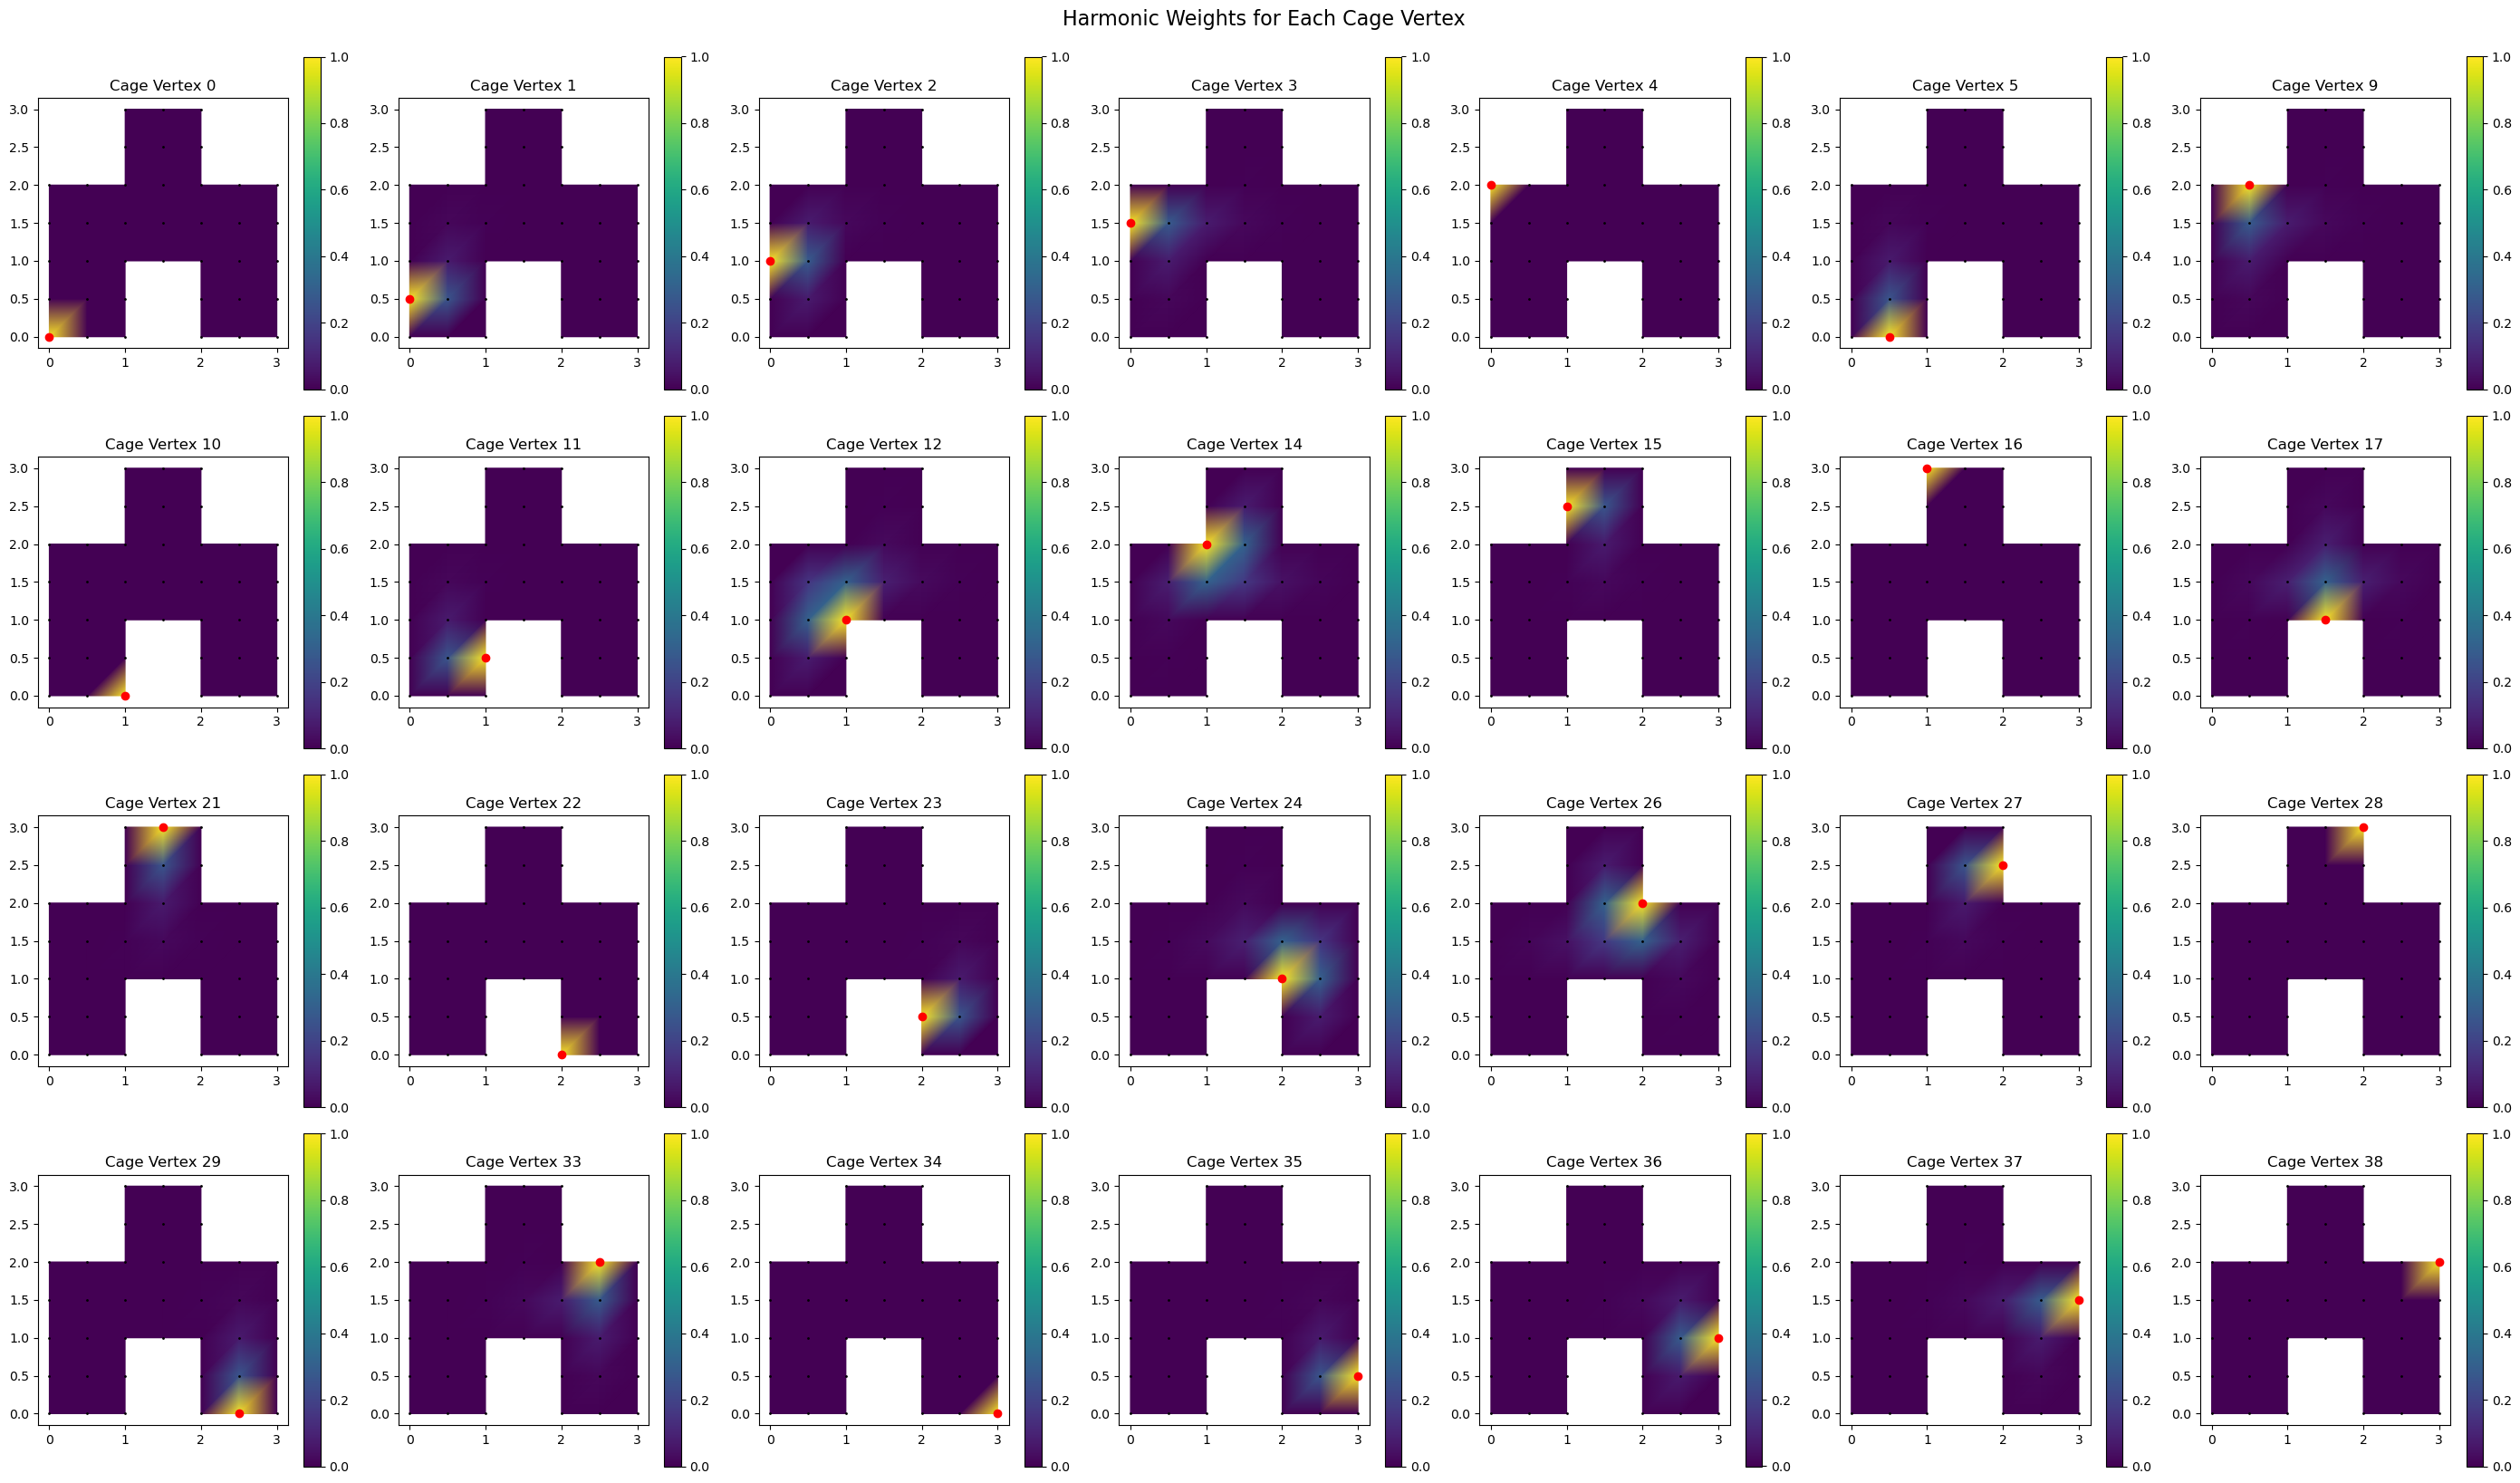

In [ ]:
visualize_harmonic_weights(pv, triangles, cage_idx_list, solved_w)

## test2 

In [2]:
src_mesh = EasyDict()

src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


	 src vertices: (11248, 3) 	 faces: (22288, 3)


In [3]:
src_mesh.f 

array([[  873,    11,   870],
       [  870,    11,  1492],
       [   17,  1189,  1190],
       ...,
       [11154, 11039, 11040],
       [11155, 11043, 11039],
       [11156,  9679, 11043]])

In [4]:
# print(src_mesh.v.min(0), src_mesh.v.max(0))


# large cube
control_mesh = EasyDict()
# quad mesh
control_mesh.f = np.array([
    [0,2,3,1],
    [0,1,5,4],
    [1,3,7,5],
    [3,2,6,7],
    [2,0,4,6],
    [5,7,6,4],
])
# make triangle great again 
control_mesh.f = control_mesh.f[:,[[3,2,1],[3,1,0]]].reshape(-1, 3)

control_mesh.v = np.zeros((8,3))

## X, Y, Z
control_mesh.v[0] = src_mesh.v.max(0)
control_mesh.v[1,0], control_mesh.v[1,1], control_mesh.v[1,2] = src_mesh.v.max(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[2,0], control_mesh.v[2,1], control_mesh.v[2,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[3,0], control_mesh.v[3,1], control_mesh.v[3,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]

control_mesh.v[4,0], control_mesh.v[4,1], control_mesh.v[4,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[5,0], control_mesh.v[5,1], control_mesh.v[5,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[6,0], control_mesh.v[6,1], control_mesh.v[6,2] = src_mesh.v.min(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[7] = src_mesh.v.min(0)

# control_mesh.v[:,1]=control_mesh.v[:,1]*1.05
control_mesh.v=control_mesh.v*1.1


control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8


In [5]:
# def creat_A_test(V, F, srcV, select_xyz=0):
#     """_summary_

#     Args:
#         V (np.ndarray): cage vertex
#         F (np.ndarray): cage triangle
#         srcV (np.ndarray): mesh vertex

#     Returns:
#         sparse matrix: A matrix
#     """
#     rows = []
#     cols = []
#     data = []

#     T = F.shape[0]
#     N = V.shape[0]
        
#     # j=0
#     M = srcV.shape[0]
#     for j in range(N):
#     # for j in range(M+N):
#         for i, t_idx in enumerate(F):  # H: (3,4)
#             rows.extend([ j for _ in range(3)])
#             cols.extend([ i*N+k for k in t_idx])
#             data.extend([ V[k][select_xyz] for k in t_idx])
#             # data.extend([ 1 for _ in range(3)])
    
#     MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(N, T*N))
#     # MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(1, T*N))
#     return MAT

def creat_A_test(V, F, srcV, select_xyz=0):
    """_summary_

    Args:
        V (np.ndarray): cage vertex
        F (np.ndarray): cage triangle
        srcV (np.ndarray): mesh vertex

    Returns:
        sparse matrix: A matrix
    """
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]
        
    j=0
    M = srcV.shape[0]
    # for j in range(N):
    # for j in range(M+N):
    for i, t_idx in enumerate(F):  # H: (3,4)
        rows.extend([ j for _ in range(3)])
        # cols.extend([ i*3+k for k in t_idx])
        cols.extend([ i*3+k for k in range(3)])
        # cols.extend([ k for k in t_idx])
        print(i*3)
        data.extend([ V[k][select_xyz] for k in t_idx])
        # data.extend([ 1 for _ in range(3)])
    print(cols, len(cols))
    # MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(N, 3*T))
    MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(1, 3*T))
    return MAT

def creat_A_test2(V, F, srcV, select_xyz=0):
    """_summary_

    Args:
        V (np.ndarray): cage vertex
        F (np.ndarray): cage triangle
        srcV (np.ndarray): mesh vertex

    Returns:
        sparse matrix: A matrix
    """
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    j=0
    M = srcV.shape[0]
    # cage vertex
    for i in range(N):
        for j in range(N):
            cols.extend([ i ])
            rows.extend([ j ])
            data.extend([ V[i][select_xyz] ])
        
            
    for i in range(M):
        for j in range(N):
            cols.extend([ i+N ])
            rows.extend([ j ])
            data.extend([ srcV[j][select_xyz] ])
    
    D = 3
    D2 = 3**2
    for i in range(M):
        tmp = D2/(D*srcV[i][select_xyz]**2)
        
        for j in range(N+M):
            cols.extend([ i+N ])
            rows.extend([ j ])
            data.extend([ tmp ])
                    
    # for i, t_idx in enumerate(F):  # H: (3,4)
    #     rows.extend([ j for _ in range(3)])
    #     # cols.extend([ i*3+k for k in t_idx])
    #     cols.extend([ i*3+k for k in range(3)])
    #     # cols.extend([ k for k in t_idx])
    #     print(i*3)
    #     data.extend([ V[k][select_xyz] for k in t_idx])
    #     # data.extend([ 1 for _ in range(3)])
    # print(cols, len(cols))
    # MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(N, 3*T))
    MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(N+M, N+M))
    return MAT

In [12]:
L = igl.cotmatrix(src_mesh.v, src_mesh.f)
print(L.shape)

_zero = scipy.sparse.csr_matrix((11248, control_mesh.v.shape[0]))
print(_zero.shape)

A_list = [L, _zero]

(11248, 11248)
(11248, 8)


In [26]:
def harmonic_weights(V, F, cage_ids):
    """
    
    Args:
        V: high-res mesh vertices (N,3)
        F: faces (M,3)
        cage_ids: cage vertices index in V (K,)
        #cage_weights: (K,K) identity matrix (boundary condition)
        
    Returns:
        (N, K) harmonic weights for all vertices
    """
    N = V.shape[0]
    K = len(cage_ids)
    L = igl.cotmatrix(V, F)
    
    cage_weights = np.eye(K)
    
    #  interior
    interior = np.setdiff1d(np.arange(N), cage_ids)
    print(interior)
    
    # W: (N, K)
    W = np.zeros((N, K))
    W[cage_ids, :] = cage_weights  # boundary condition
    print(W.shape, W[cage_ids, 0])
    
    L_ii = L[interior][:, interior]
    L_ib = L[interior][:, cage_ids]
    
    print(L_ii.shape, L_ib.shape)
    
    for k in range(K):
        b = -L_ib @ W[cage_ids, k]
        W[interior, k] = spsolve(L_ii, b)
    return W


In [27]:

www = harmonic_weights(src_mesh.v, src_mesh.f, np.array([0,100]))

[    1     2     3 ... 11245 11246 11247]
(11248, 2) [1. 0.]
(11246, 11246) (11246, 2)


In [ ]:
A_ = scipy.sparse.hstack(A_list, format='csr')

zero_ = scipy.sparse.csr_matrix((11248, control_mesh.v.shape[0]))

C_ = scipy.sparse.hstack([zero_ ], format='csr')
A_list = [A_, _zero]

In [6]:

A = creat_A_test2(control_mesh.v, control_mesh.f, src_mesh.v)
A.todense()

MemoryError: 

In [123]:
print(control_mesh.f.reshape(-1))
print(control_mesh.f.shape)
print(control_mesh.v.shape)

[1 3 2 1 2 0 4 5 1 4 1 0 5 7 3 5 3 1 7 6 2 7 2 3 6 4 0 6 0 2 4 6 7 4 7 5]
(12, 3)
(8, 3)


In [133]:
# # creat_A_test(control_mesh.v, control_mesh.f)
# A = creat_A_test(control_mesh.v, control_mesh.f, src_mesh.v)
# print(A.shape)
# A.todense()

In [103]:
# A = control_mesh.v.transpose(1,0)
# A = creat_A_test(control_mesh.v, control_mesh.f)
A = creat_A_test(control_mesh.v, control_mesh.f, src_mesh.v)
lu = lu_factor_ata(A)
# b = np.r_[np.zeros((src_mesh.v.shape[0],1)), np.ones((control_mesh.v.shape[0],1))] 
b = np.r_[np.zeros(src_mesh.v.shape), control_mesh.v] 
print(A.shape, b.shape)

RuntimeError: Factor is exactly singular

In [14]:
Atb = A.T @ b
print(Atb.shape)

(8, 11256)


AttributeError: 'numpy.ndarray' object has no attribute 'tocsc'

In [ ]:
V_transferred = lu.solve(Atb)

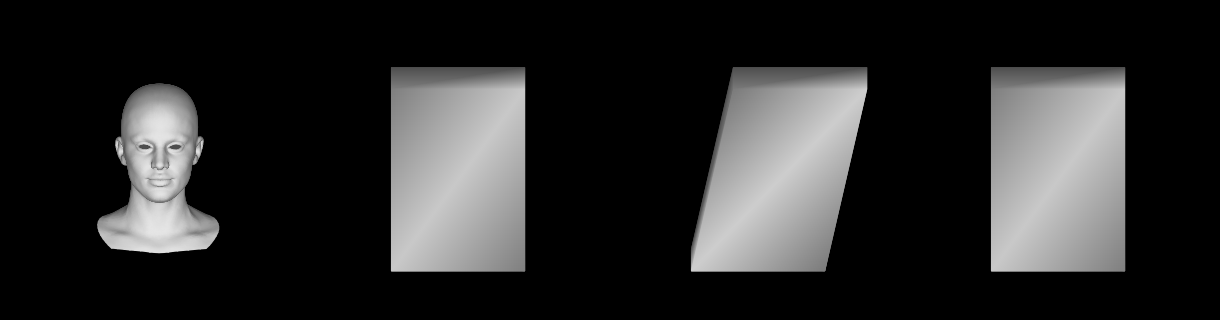

In [5]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

v_list=[ src_mesh.v, control_mesh.v, control_mesh_v2, np.r_[src_mesh.v, control_mesh.v]]
f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, np.r_[src_mesh.f, control_mesh.f+src_mesh.f.max()+1]]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

## Mean Value Coordinate function

In [15]:
def MVC(src_mesh, control_mesh, _func_=None, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        _func_ (np.ndarry, optional): function on control mesh vertex to interpolate. Defaults to None.
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: new vertices for source mesh
    """
    
    if _func_ is None:
        _func_ = control_mesh.v

    # new_v = np.zeros_like(src_mesh.v)
    
    new_F = np.zeros_like(src_mesh.v)
    new_W = np.zeros(src_mesh.v.shape[0])
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
            
            # if dj[jdx] < eps:
            #     new_v[vdx] = _func_[jdx]
                
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tri_idx in control_mesh.f:
            
            f0, f1, f2 = _func_[tri_idx]
            i0, i1, i2 = tri_idx
            
            # print(i0, i1, i2)
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                determinant = np.linalg.det(Uj[tri_idx])
                sign = -1 if determinant < 0 else 1
                
                s0 = sign * np.sqrt(1-c0**2)
                s1 = sign * np.sqrt(1-c1**2)
                s2 = sign * np.sqrt(1-c2**2)
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
    return new_F / new_W[..., None]


def MVC_weight(src_mesh, control_mesh, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: weight to control mesh vertices for each source vertex
    """
    
    new_W = np.zeros((src_mesh.v.shape[0], control_mesh.f.shape[0], 3))
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
                            
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            i0, i1, i2 = tri_idx
            
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                # determinant = np.linalg.det(Uj[tri_idx])
                # sign = -1 if determinant < 0 else 1
                
                # s0 = sign * np.sqrt(1-c0**2)
                # s1 = sign * np.sqrt(1-c1**2)
                # s2 = sign * np.sqrt(1-c2**2)
                s0 = np.abs(np.sqrt(1-c0**2))
                s1 = np.abs(np.sqrt(1-c1**2))
                s2 = np.abs(np.sqrt(1-c2**2))
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
    return new_W

def apply_MVC_weight(new_W, control_mesh, _func_=None):
    new_V = np.zeros((src_mesh.v.shape[0], 3))
    new_VW = np.zeros((src_mesh.v.shape[0]))
    
    for vdx in range(new_W.shape[0]):
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            f0, f1, f2 = _func_[tri_idx]
            
            new_V[vdx] += (new_W[vdx][tdx][0] * f0) + (new_W[vdx][tdx][1] * f1) + (new_W[vdx][tdx][2] * f2)
            new_VW[vdx] += new_W[vdx][tdx].sum(0)
            
    new_V = new_V / new_VW[...,None]
    return new_V

# Run

### all in one

In [16]:
new_v = MVC(src_mesh, control_mesh, control_mesh_v2)

### save weight and apply later

In [11]:
new_w = MVC_weight(src_mesh, control_mesh, control_mesh_v2)
new_w.shape


(11248, 12, 3)

In [13]:
new_v2 = apply_MVC_weight(new_w, control_mesh, control_mesh_v2)

In [8]:
print(src_mesh.v.min(0), src_mesh.v.max(0))
print(new_v.min(0), new_v.max(0))

[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[-1.05129244 -1.81234658 -1.37132633] [1.33846999 1.3834517  0.78344184]


## Visualize

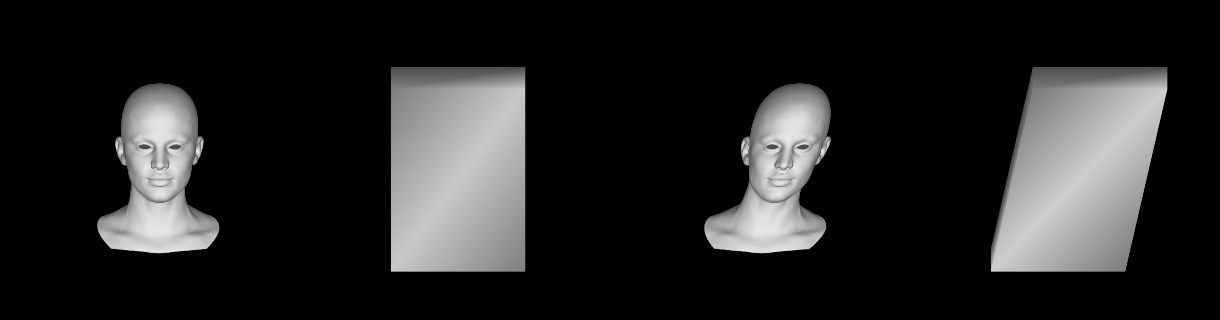

In [33]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        new_v2, 
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:

from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms


def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def area_of_polygon(verts):
        # 각 spherical triangle의 면적 계산 (Girard's theorem 사용)
        def angle(a, b):
            return np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

        total_area = 0.0
        for i in range(1, len(verts) - 1):
            a = verts[0]
            b = verts[i]
            c = verts[i + 1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            # spherical excess
            excess = alpha + beta + gamma - np.pi
            total_area += excess
        return total_area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = area_of_polygon(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_weights(v0, cage_vertices, cage_function):
    sphere_points, directions, norms = project_to_unit_sphere(v0, cage_vertices)
    weights = compute_spherical_voronoi_area(sphere_points)
    weights /= np.sum(weights)  # normalize

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output

def cage_based_interpolation(target_vertices, cage_vertices, cage_function):
    outputs = []
    for v0 in target_vertices:
        out = interpolate_using_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
    return np.array(outputs)


#############


import numpy as np
from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms.squeeze()

def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def angle(u, v):
        return np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))

    def spherical_polygon_area(verts):
        # triangulate with fan method
        area = 0.0
        for i in range(1, len(verts) - 1):
            a, b, c = verts[0], verts[i], verts[i+1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            excess = alpha + beta + gamma - np.pi
            area += excess
        return area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = spherical_polygon_area(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function, eps=1e-8):
    sphere_points, directions, distances = project_to_unit_sphere(v0, cage_vertices)
    areas = compute_spherical_voronoi_area(sphere_points)
    volumes = (1/3) * areas * distances  # cone volumes

    volumes = np.maximum(volumes, eps)  # ensure non-zero
    weights = volumes / np.sum(volumes)

    offset_sum = np.sum(weights[:, None] * (cage_vertices - v0), axis=0)
    zero_check = np.linalg.norm(offset_sum)

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output, weights, offset_sum, zero_check

def cage_interpolation_cone_method(target_vertices, cage_vertices, cage_function):
    outputs, all_weights, all_checks = [], [], []
    for v0 in target_vertices:
        out, w, offset, norm_check = interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
        all_weights.append(w)
        all_checks.append(norm_check)
    return np.array(outputs), np.array(all_weights), np.array(all_checks)


In [31]:
output = cage_based_interpolation(src_mesh.v, control_mesh.v, control_mesh_v2)

# output2 = cage_interpolation_cone_method(src_mesh.v, control_mesh.v, control_mesh_v2)


In [30]:
# print(output2[1], output2[2])

[[2.49802974e-01 4.76081308e-02 1.79420329e-01 ... 9.38144764e-02
  1.92847058e-01 1.01489131e-09]
 [2.43638093e-01 5.33469882e-02 1.76273986e-01 ... 9.35072418e-02
  1.91775181e-01 1.01325429e-09]
 [2.48033272e-01 4.91658302e-02 1.78476283e-01 ... 9.30644282e-02
  1.92970363e-01 1.01405411e-09]
 ...
 [6.73587097e-02 2.11859283e-01 9.86086542e-10 ... 1.50162822e-01
  9.51249911e-02 1.68019646e-01]
 [4.19428202e-02 2.14076221e-01 9.87369198e-10 ... 1.62962084e-01
  1.02151173e-01 1.63965198e-01]
 [1.90511882e-02 2.15257629e-01 9.93278857e-10 ... 1.76618831e-01
  1.09128652e-01 1.57270118e-01]] [0.31477486 0.30695969 0.31292799 ... 1.10993081 1.00910788 0.91695508]


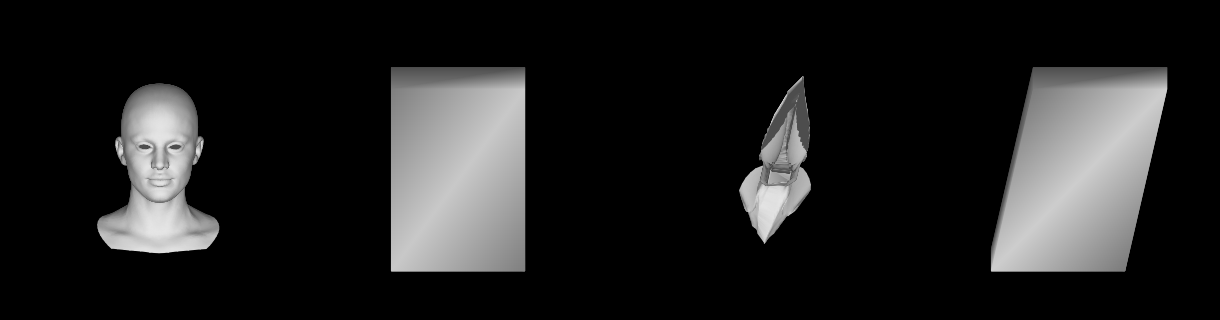

In [29]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output[0],
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

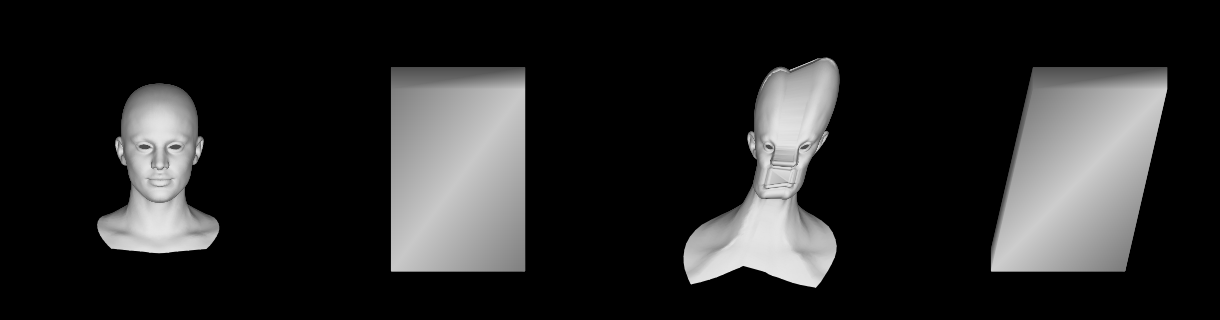

In [24]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output,
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')